In [1]:
import pynq
# from pynq import Overlay
from pynq import BCI_Overlay
from pynq.lib import DMA
from pynq import Xlnk
from pynq import Interrupt
# from pynq import FFTDriver
# from pynq import FIRDriver

import numpy as np
import matplotlib
import math
import pandas as pd
from matplotlib import pyplot as plt
import asyncio
import scipy
from scipy.io import wavfile
from scipy.io import loadmat
import csv
from scipy.signal import lfilter, freqz, firwin
from scipy import signal, stats
import sys
import pandas as pd
sys.path.insert(0, '/home/xilinx/mne-python/')
import mne
import cffi
import timeit
import time

In [2]:
overlay = BCI_Overlay.BCI_Overlay("version3.bit")

In [3]:
fs,aud_in = wavfile.read("/home/xilinx/assets/audio_files/600Hz_8kHz_samp_noise.wav")

In [4]:
def plot_to_notebook(time_sec, input_sig, title, samples = None, out_signal=None):
    print('Number of samples: ',len(input_sig))
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams["font.size"] = 22
    plt.figure()
    plt.subplot(1,1,1)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Voltage (uV)")
    plt.grid()
    if samples is None:
        plt.plot(time_sec, input_sig, label=title)
    else:    
        plt.plot(time_sec[:samples], input_sig[:samples], 'y-', label=title)

    if out_signal is not None:
        plt.plot(time_sec, out_signal, 'g-', label='Filtered Signal')
    
    plt.title(title)
    plt.savefig("Original Signal")
    plt.legend()
    plt.show()

In [5]:
def plot_fir_response(coeffs, f_samp):
        freqs, resp = freqz(coeffs, 1)
        plt.plot(freqs/math.pi, np.abs(resp))
        plt.rcParams["figure.figsize"] = (20,10)
        plt.rcParams["font.size"] = 22
        plt.title("Magnitude Response")
        plt.xlabel("Normalised Frequency (Pi radiens/sample)")
        plt.ylabel("Magnitude")
        plt.savefig("FIR Response")
        plt.show()
    

Number of samples:  1600


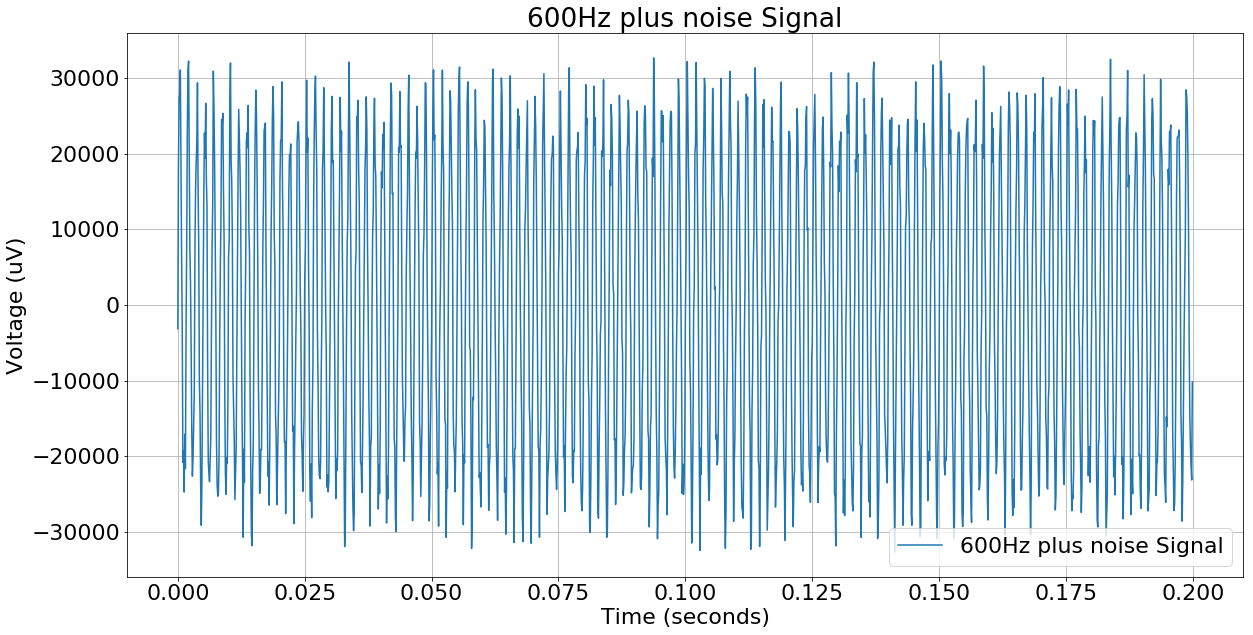

In [6]:
T = .2
n = int(T * fs)
t = np.linspace(0, T, n, endpoint=False)
audio_data = aud_in[np.int16(fs*.2):np.int16(fs*.4)]
plot_to_notebook(t, audio_data, "600Hz plus noise Signal")


0
1
2
3


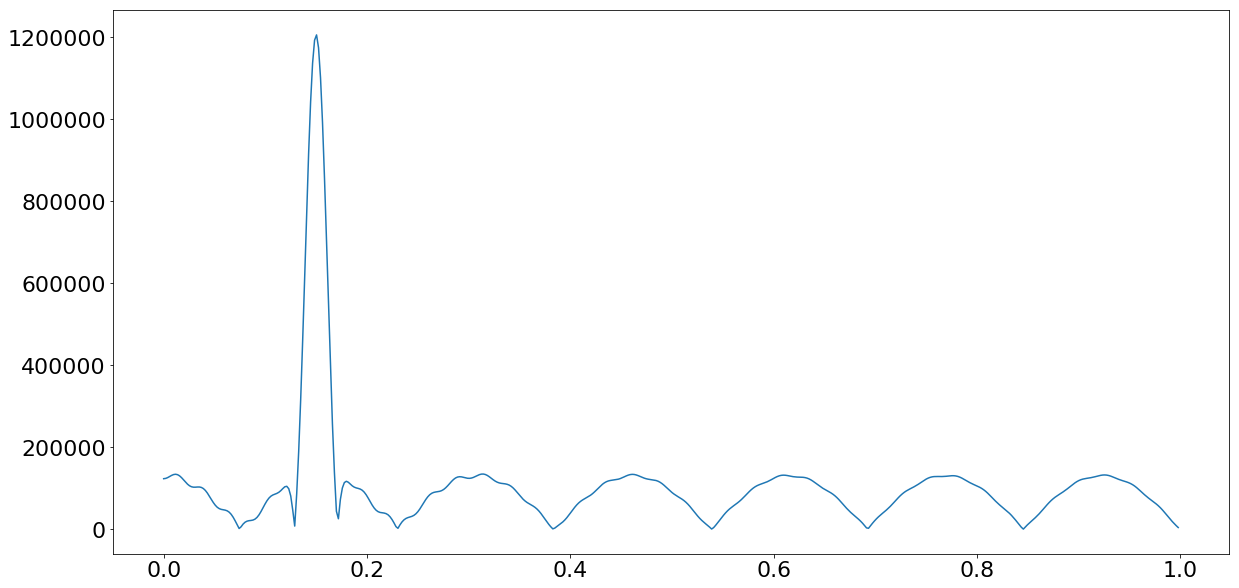

Configuration Complete
Configuration Complete
Configuration Complete
Configuration Complete


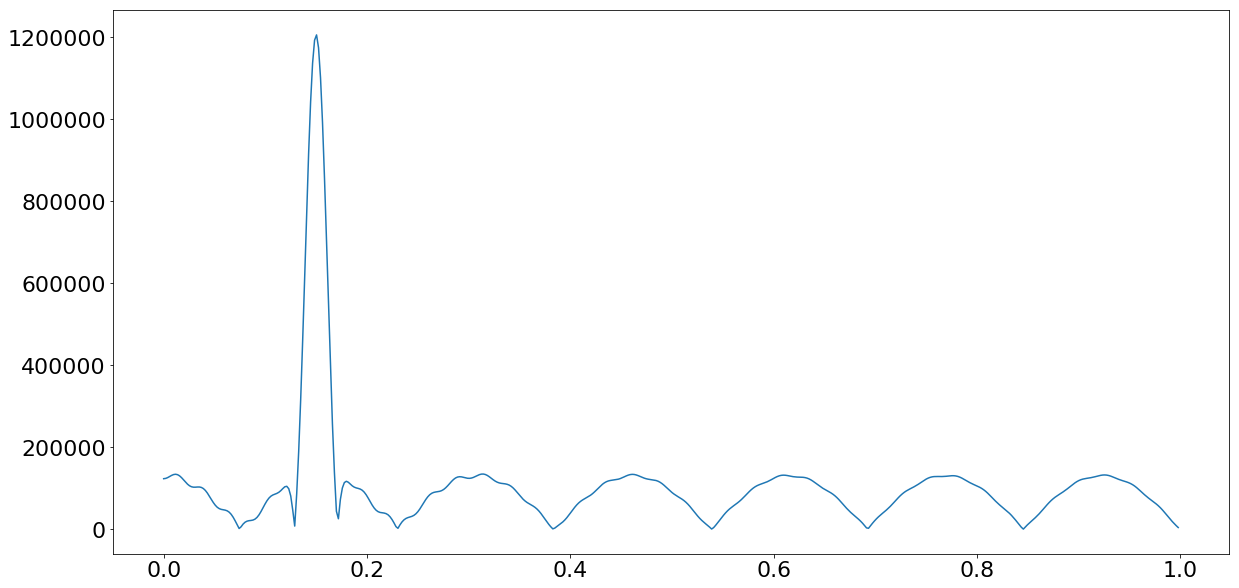

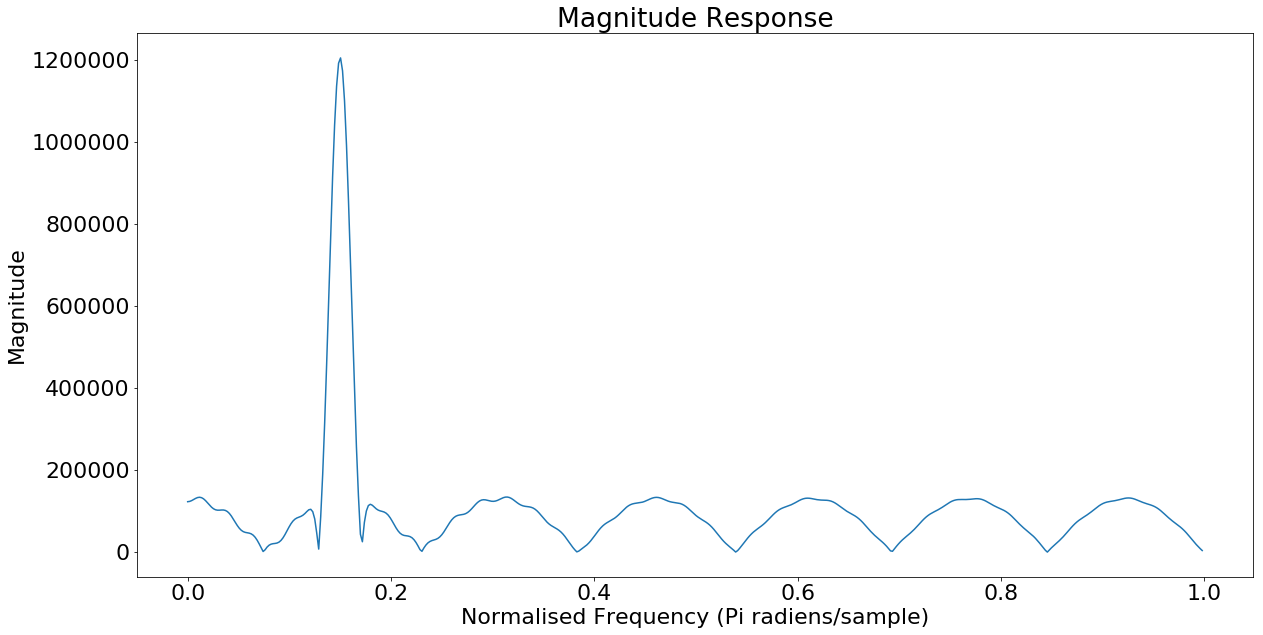

In [7]:
N = 10
NFFT = 2**N
audio_data = audio_data[0:NFFT]
overlay.configure_HW_FFT(True, [ 3, 3, 3, 3, 3, 3], NFFT, fs)
overlay.configure_HW_FIR(fs, 590, 610, NFFT)
coeffs = overlay.filter_design(fs, 590, 610)
plot_fir_response(coeffs,fs)

HW FFT excl Transfer latencies: 0.0014801870000056283
Data Received
CPU times: user 36 ms, sys: 19.9 ms, total: 55.9 ms
Wall time: 82.1 ms


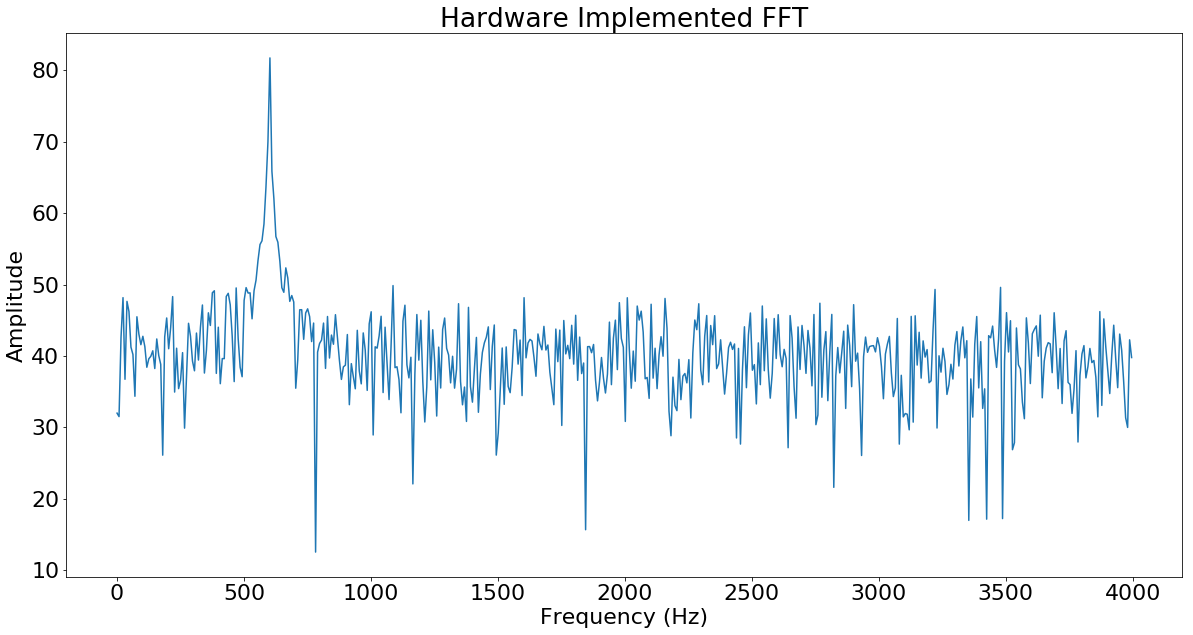

In [8]:
%time hw_fft = overlay.FFT_Hierarchy.FFT_channelO1.fft_hw(audio_data, NFFT)
df = overlay.to_freq_dataframe(20*np.log10(np.abs(hw_fft)), fs)
plt.plot(df["freq"],df["amplitude"])
plt.title("Hardware Implemented FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.savefig("HW FFT")
plt.show()

CPU times: user 2.83 ms, sys: 84 µs, total: 2.92 ms
Wall time: 1.64 ms


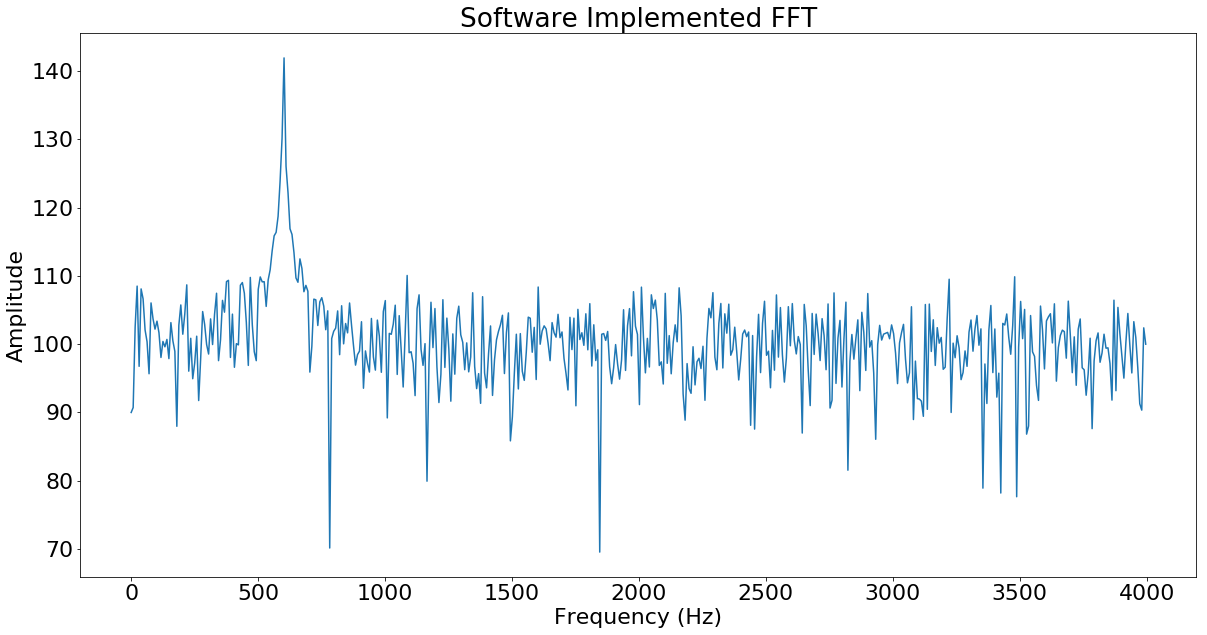

In [9]:
%time sw_fft = scipy.fft(audio_data, NFFT)
df2 = overlay.to_freq_dataframe(20*np.log10(np.abs(sw_fft)), fs)
plt.plot(df2["freq"], df2["amplitude"])
plt.title("Software Implemented FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.savefig("SW FFT")
plt.show()

HW FIR excl Transfer latencies: 0.0017714500427246094
CPU times: user 41.1 ms, sys: 10 ms, total: 51.1 ms
Wall time: 71.5 ms


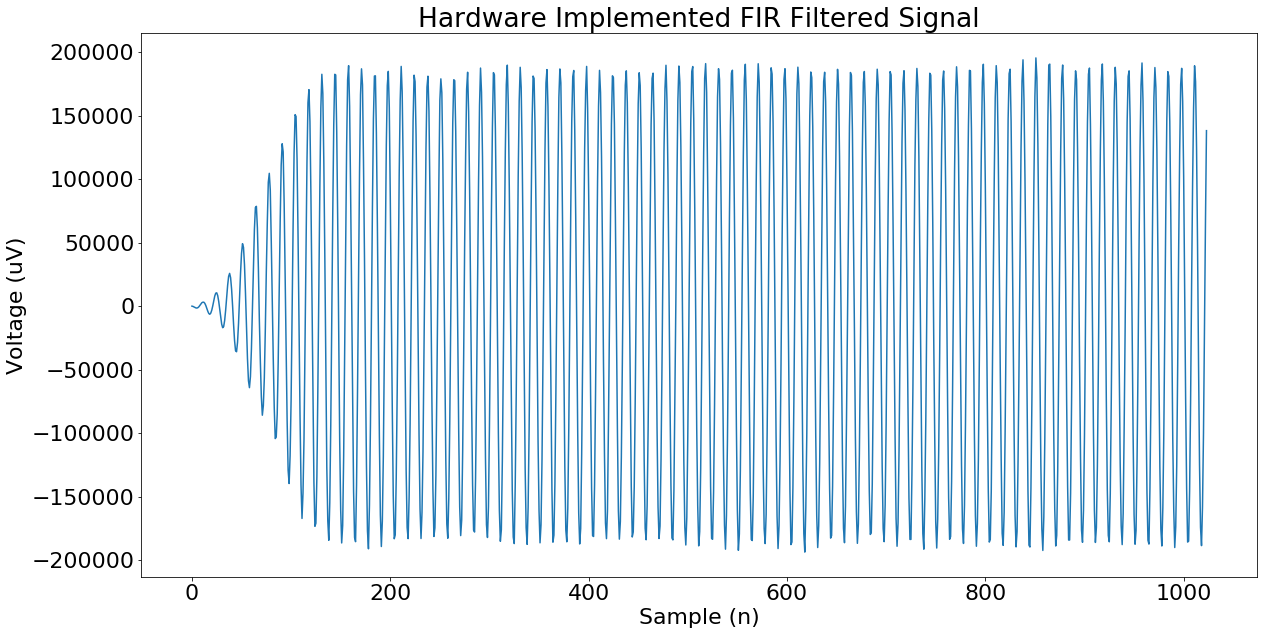

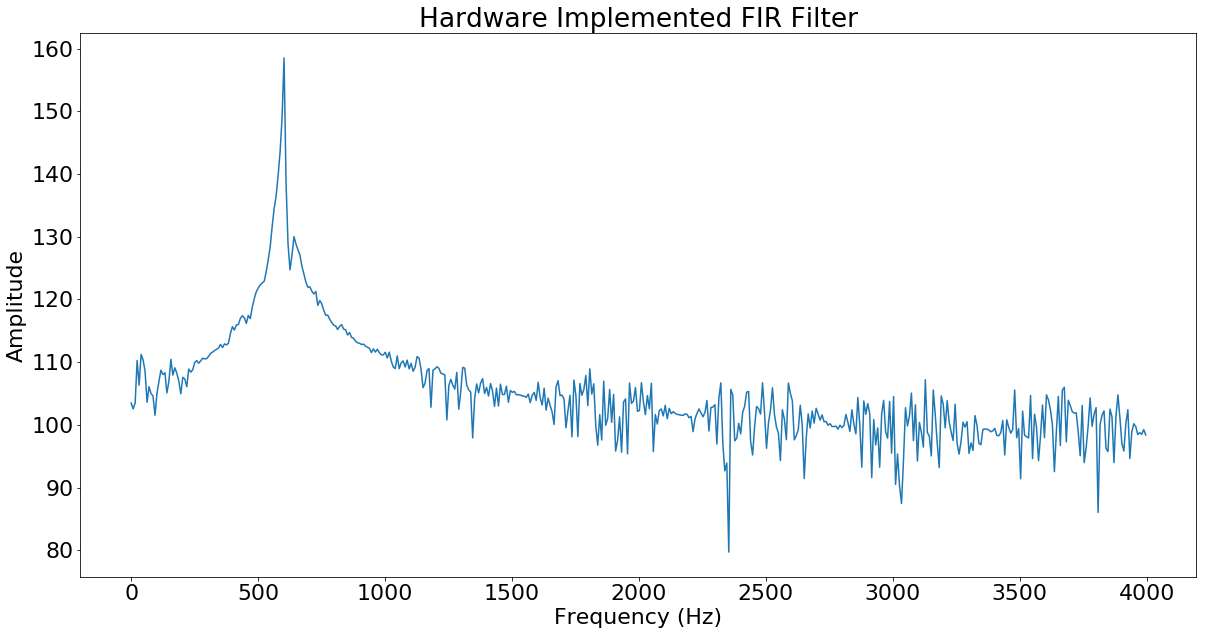

In [10]:
%time filtered_HW = overlay.Filter_Hierarchy.FIR_channelO1.filter_signal(audio_data)
plt.plot(filtered_HW)
plt.title("Hardware Implemented FIR Filtered Signal")
plt.xlabel("Sample (n)")
plt.ylabel("Voltage (uV)")
plt.savefig("HW FIR Signal")
plt.show()

df3 = overlay.to_freq_dataframe(20*np.log10(np.abs(scipy.fft(filtered_HW, NFFT))), fs)
plt.plot(df3["freq"], df3["amplitude"])
plt.title("Hardware Implemented FIR Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.savefig("HW FIR Freq Response")
plt.show()

CPU times: user 4 ms, sys: 108 µs, total: 4.1 ms
Wall time: 2.85 ms


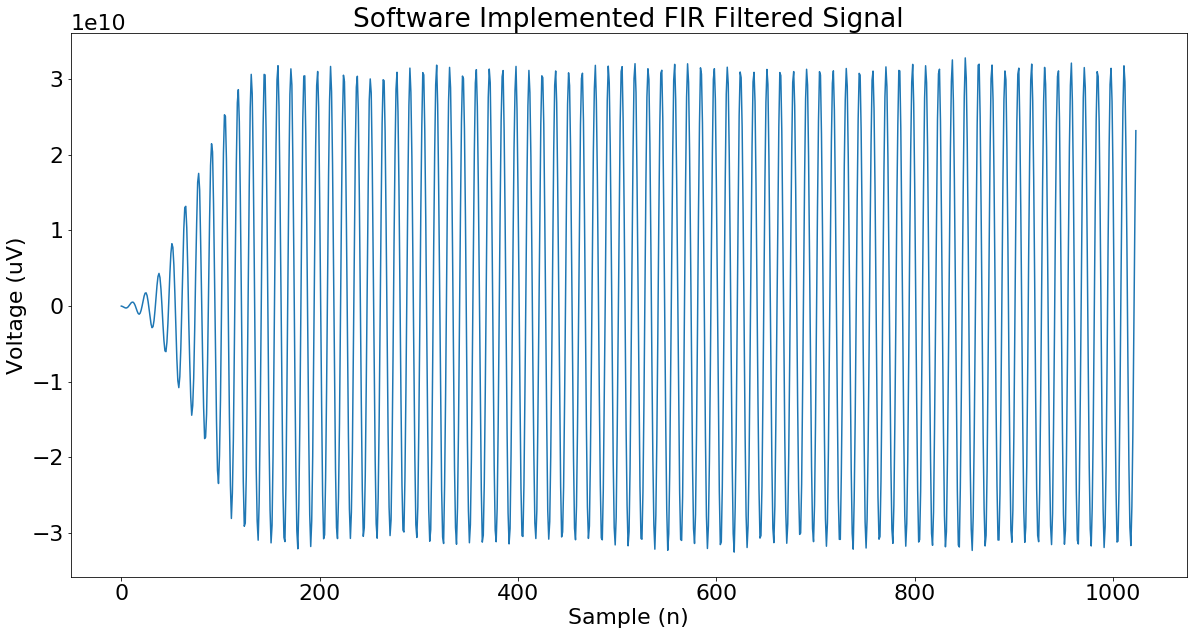

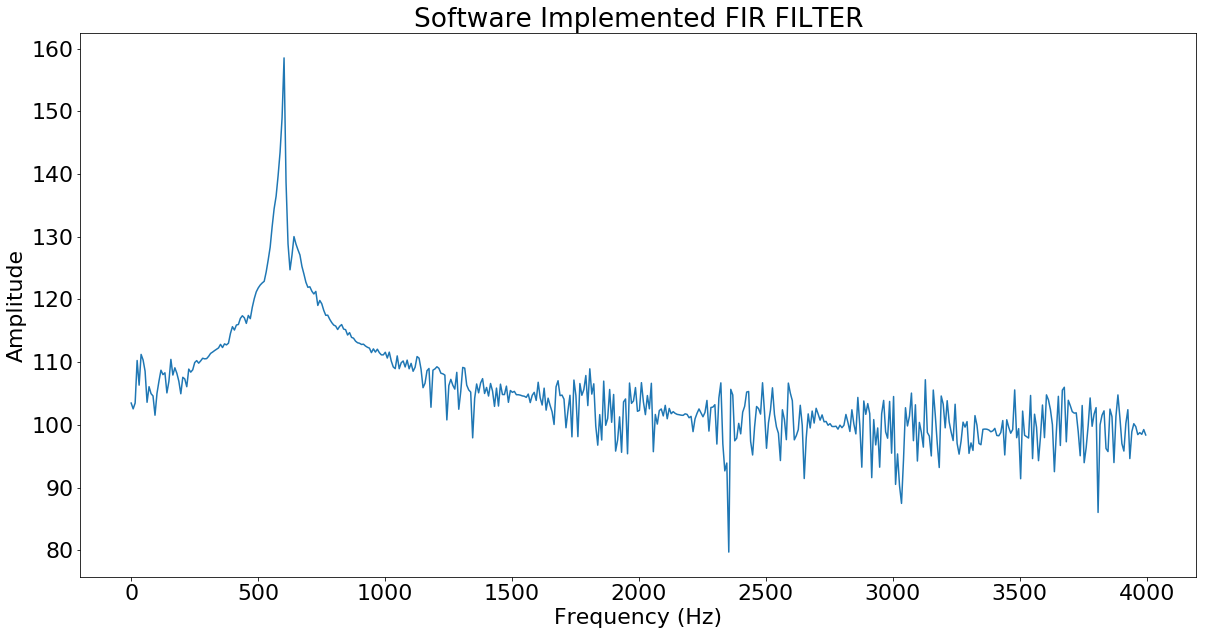

In [11]:
%time filtered_SW = lfilter(coeffs, 1.0, audio_data) 
plt.plot(filtered_SW)
plt.title("Software Implemented FIR Filtered Signal")
plt.xlabel("Sample (n)")
plt.ylabel("Voltage (uV)")
plt.savefig("SW FIR Signal")
plt.show()

df4 = overlay.to_freq_dataframe(20*np.log10(np.abs(scipy.fft(filtered_HW, NFFT))), fs)
plt.plot(df4["freq"], df4["amplitude"])
plt.title("Software Implemented FIR FILTER")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.savefig("SW FIR Freq Response")
plt.show()

In [12]:
print("Mean difference between the Hardware and Software FFT Implementations")
np.mean(np.abs(df["amplitude"].to_numpy() - df2["amplitude"].to_numpy()))

Mean difference between the Hardware and Software FFT Implementations


60.199492431402611

In [13]:
print("Mean difference between the Hardware and Software FIR Implementations")
np.mean(np.abs(filtered_HW - filtered_SW))

Mean difference between the Hardware and Software FIR Implementations


18657390246.214844

In [14]:
%timeit overlay.FFT_Hierarchy.FFT_channelO1.fft_hw(audio_data, NFFT)

HW FFT excl Transfer latencies: 0.0018497070000051963
Data Received
HW FFT excl Transfer latencies: 0.0008446150000054331
Data Received
HW FFT excl Transfer latencies: 0.0008405069999923853
Data Received
HW FFT excl Transfer latencies: 0.0008390769999948589
Data Received
HW FFT excl Transfer latencies: 0.0008325569999954041
Data Received
HW FFT excl Transfer latencies: 0.0008286119999922903
Data Received
HW FFT excl Transfer latencies: 0.0008383349999974143
Data Received
HW FFT excl Transfer latencies: 0.0008439289999984112
Data Received
HW FFT excl Transfer latencies: 0.0008305570000004536
Data Received
HW FFT excl Transfer latencies: 0.0008464929999973947
Data Received
HW FFT excl Transfer latencies: 0.0008373749999890379
Data Received
HW FFT excl Transfer latencies: 0.000842934999994327
Data Received
HW FFT excl Transfer latencies: 0.0009739909999950669
Data Received
HW FFT excl Transfer latencies: 0.0008337139999952115
Data Received
HW FFT excl Transfer latencies: 0.000841344999997

In [15]:
%timeit scipy.fft(audio_data, NFFT)

1000 loops, best of 3: 561 µs per loop


In [16]:
%timeit overlay.Filter_Hierarchy.FIR_channelO1.filter_signal(audio_data)

HW FIR excl Transfer latencies: 0.0013480186462402344
HW FIR excl Transfer latencies: 0.001321554183959961
HW FIR excl Transfer latencies: 0.0013384819030761719
HW FIR excl Transfer latencies: 0.0013308525085449219
HW FIR excl Transfer latencies: 0.0013380050659179688
HW FIR excl Transfer latencies: 0.0014414787292480469
HW FIR excl Transfer latencies: 0.0013413429260253906
HW FIR excl Transfer latencies: 0.0013375282287597656
HW FIR excl Transfer latencies: 0.001332998275756836
HW FIR excl Transfer latencies: 0.0013675689697265625
HW FIR excl Transfer latencies: 0.0013437271118164062
HW FIR excl Transfer latencies: 0.0013477802276611328
HW FIR excl Transfer latencies: 0.0014119148254394531
HW FIR excl Transfer latencies: 0.0013277530670166016
HW FIR excl Transfer latencies: 0.0013394355773925781
HW FIR excl Transfer latencies: 0.0013337135314941406
HW FIR excl Transfer latencies: 0.0013430118560791016
HW FIR excl Transfer latencies: 0.0013394355773925781
HW FIR excl Transfer latencies

In [18]:
%timeit lfilter(coeffs, 1.0, audio_data) 

The slowest run took 4.70 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.17 ms per loop


In [25]:
matfile = loadmat("/home/xilinx/assets/eeg_data/EID-S.mat")

In [35]:
matfile["eeg_close_8sub_1file"][:,0]

array([ 4202.05126953,  4197.94873047,  4188.71777344, ...,  4131.28173828,
        4142.05126953,  4136.41015625])

In [23]:
matfile

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 22 13:29:50 2017',
 '__version__': '1.0',
 'eeg_close_ubicomp_8sub': array([[  4.20205127e+03,   4.20615381e+03,   4.16923047e+03, ...,
           4.10051270e+03,   4.17282031e+03,   1.00000000e+00],
        [  4.19794873e+03,   4.20000000e+03,   4.16820508e+03, ...,
           4.10000000e+03,   4.17128174e+03,   1.00000000e+00],
        [  4.18871777e+03,   4.19846143e+03,   4.16974365e+03, ...,
           4.11589746e+03,   4.17692285e+03,   1.00000000e+00],
        ..., 
        [  4.14461523e+03,   4.22102539e+03,   4.15846143e+03, ...,
           4.07846143e+03,   4.12666650e+03,   8.00000000e+00],
        [  4.14102539e+03,   4.21230762e+03,   4.15538428e+03, ...,
           4.07538452e+03,   4.12512793e+03,   8.00000000e+00],
        [  4.13538428e+03,   4.20769238e+03,   4.15384619e+03, ...,
           4.07589722e+03,   4.12256396e+03,   8.00000000e+00]])}